In [2]:
import os
import time
import csv
from PIL import Image
from tqdm import tqdm 
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from torchvision.transforms.v2 import ToDtype
from torchvision.transforms import Normalize

In [56]:
pip install scripts

  Obtaining dependency information for scripts from https://files.pythonhosted.org/packages/41/49/1825670202a0619ac42c61147c0e5361afb84b866c279144dbad5f4a8267/scripts-3.0-py3-none-any.whl.metadata
  Obtaining dependency information for stua from https://files.pythonhosted.org/packages/d4/b9/0a8e7e66bf02ec3c7f4f5be0765cba0dec6f6acd074c956eb2b49bf33f39/stua-0.3-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [101]:
file_path = 'activity_categories.csv'
if os.path.exists(file_path):
    print("Файл найден.")
else:
    print("Файл не найден.")

Файл найден.


In [61]:
pip install dataset-manager

  Obtaining dependency information for dataset-manager from https://files.pythonhosted.org/packages/ce/c0/935cab3b1b7932892c9579e00b147c58103b4b0363437967782cd3374318/dataset_manager-0.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for fs<2.5.0 from https://files.pythonhosted.org/packages/b9/5c/a3d95dc1ec6cdeb032d789b552ecc76effa3557ea9186e1566df6aac18df/fs-2.4.16-py2.py3-none-any.whl.metadata
  Obtaining dependency information for fs.archive<0.7.0 from https://files.pythonhosted.org/packages/e2/d4/aa28ed850991d7ab1810e73c996bbf0a897ec34320129600f5e04e44d86a/fs.archive-0.6.2-py2.py3-none-any.whl.metadata
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Obtaining dependency information for a


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [111]:
# Преобразования для данных
transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ColorJitter(brightness=0.5),  # Уменьшение яркости
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Параметры
source_directory = r'D:\data sets\ml-intensive-yandex-academy-autumn-2024\human_poses_data'
csv_train_ans = 'D:\\data sets\\ml-intensive-yandex-academy-autumn-2024\\human_poses_data\\train_answers.csv'
root_dir_train = 'D:\\data sets\\ml-intensive-yandex-academy-autumn-2024\\human_poses_data\\img_train'
root_dir_test = 'D:\\data sets\\ml-intensive-yandex-academy-autumn-2024\\human_poses_data\\img_test'
activity_categories_file = 'activity_categories.csv'

# Преобразования для данных
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.5),  # Уменьшение яркости
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [112]:
# Загрузка категорий
activity_categories = pd.read_csv(activity_categories_file)
category_map = dict(zip(activity_categories['id'], activity_categories['category']))

# Загрузка данных
full_dataset = datasets.ImageFolder(root=source_directory, transform=transform)

# Разделение на обучающую и валидационную выборки (80% на обучение и 20% на валидацию)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame) * 2

    def __getitem__(self, idx):
        if idx % 2 == 0:
            img_name = os.path.join(self.root_dir, str(self.data_frame.iloc[idx // 2, 0]) + ".jpg")  # ID изображений в первом столбце
            image = Image.open(img_name).convert('RGB')
            label = self.data_frame.iloc[idx // 2, 1]  # Метки во втором столбце
        else:
            img_name = os.path.join(self.root_dir,
                                    str(self.data_frame.iloc[idx // 2, 0]) + ".jpg")  # ID изображений в первом столбце
            image = Image.open(img_name).convert('RGB')
            image.transpose(Image.FLIP_LEFT_RIGHT)
            label = self.data_frame.iloc[idx // 2, 1]  # Метки во втором столбце

        if self.transform:
            image = self.transform(image)

        return image, label

class CustomTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data_frame = os.listdir(root_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.data_frame[idx]))
        image = Image.open(img_name).convert('RGB')
        label = self.data_frame[idx].replace(".jpg", '')

        if self.transform:
            image = self.transform(image)
        
        return image, int(label)

def get_dataloader(ratio: tuple[float, float] = (0.9, 0.1),
                    csv_file: str = csv_train_ans,
                    root_dir: str = root_dir_train,
                    transform=transforms.Compose([
                        transforms.Resize((128, 128)),
                        transforms.ToTensor(),
                        ToDtype(torch.float32, scale=True),
                        Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))])
                   ) -> tuple:
    train_ds, test_ds = random_split(CustomDataset(csv_file=csv_file, root_dir=root_dir, transform=transform), ratio)
    return DataLoader(train_ds, batch_size=128, shuffle=True), DataLoader(test_ds, batch_size=128, shuffle=True)

In [113]:
def get_dataloader(ratio: tuple[float, float] = (0.9, 0.1),
                    csv_file: str = csv_train_ans,
                    root_dir: str = root_dir_train,
                    transform=transforms.Compose([
                        transforms.Resize((128, 128)),
                        transforms.ToTensor(),
                        ToDtype(torch.float32, scale=True),
                        Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))])
                   ) -> tuple:
    train_ds, test_ds = random_split(CustomDataset(csv_file=csv_file, root_dir=root_dir, transform=transform), ratio)
    return DataLoader(train_ds, batch_size=128, shuffle=True), DataLoader(test_ds, batch_size=128, shuffle=True)

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

model = ResNet18(num_classes=10)

# Замена последнего слоя
num_classes = len(full_dataset.classes)  # Количество классов в вашем датасете
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [114]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Для обучения выбран девайс {}".format(device))

model.to(device)

Для обучения выбран девайс cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [115]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1 

# Инициализация списков для хранения метрик
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    correct = 0
    total = 0

    start_time = time.time()  # Запомнить время начала эпохи

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Сохранение меток и предсказаний для F1 Score
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

        # Обновление correct и total
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()  # Запомнить время конца эпохи
    epoch_time = end_time - start_time  # Вычислить время эпохи

    # Вычисление среднего лосса за эпоху и F1 Score
    epoch_loss = running_loss / len(train_loader)
    train_f1 = f1_score(all_labels, all_preds, average='weighted')

    # Сохранение метрик
    train_losses.append(epoch_loss)
    train_accuracies.append(correct / total * 100)  # Точность в процентах

    # Валидация
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    val_all_labels = []
    val_all_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            # Сохранение меток и предсказаний для F1 Score
            _, predicted = torch.max(outputs.data, 1)
            val_all_labels.extend(labels.cpu().numpy())
            val_all_preds.extend(predicted.cpu().numpy())

            # Обновление val_correct и val_total
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Вычисление валидационного лосса и точности
    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_correct / val_total * 100  # Валидационная точность в процентах
    val_losses.append(val_loss)  # Сохранение валидационного лосса
    val_accuracies.append(val_accuracy)  # Сохранение валидационной точности
    val_f1 = f1_score(val_all_labels, val_all_preds, average='weighted')

    # Вывод результатов
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, F1 Score: {train_f1:.4f}, Accuracy: {correct/total*100:.2f}%, Time: {epoch_time:.2f} sec")
    print(f"Validation Loss: {val_loss:.4f}, Validation F1 Score: {val_f1:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

print("Обучение завершено!")


def get_result(model: torch.nn.Module, transform: transforms.Compose, category_map: dict):
    # Создание тестового датасета и загрузчика
    dataset = CustomTestDataset(root_dir_test, transform=transform)
    dl = DataLoader(dataset, batch_size=128)

    model.eval()  # Установка модели в режим оценки
    ans = []

    # Перебор данных в загрузчике
    for img, label in tqdm(dl):
        img = img.to(device)  # Перемещение изображений на устройство
        label = label.to(device)  # Перемещение меток на то же устройство
        pred = model(img)  # Предсказания модели
        preds = torch.argmax(pred, dim=1)

        # Конкатенация меток и предсказаний
        res = torch.cat((label.unsqueeze(1), preds.unsqueeze(1)), dim=1)
        ans.extend(res.cpu())  # Перемещение результата на CPU для дальнейшей обработки

    # Проверка, есть ли данные в ans
    if not ans:
        print("Ошибка: массив ans пуст. Проверьте процесс предсказания.")
        return

    # Преобразование ans в список
    ans = [[element.item() for element in row] for row in ans]

    # Создание списка для сохранения результатов с номерами категорий
    results_with_categories = []
    
    for id, pred in ans:
        results_with_categories.append([id, pred])  # Сохраняем ID и номер предсказанной категории

    # Убедитесь, что файл будет создан в текущей директории
    output_file = 'result.csv'  # Сохраняем в текущей директории

    # Запись результатов в CSV файл
    try:
        with open(output_file, 'w', newline="") as out_file:
            writer = csv.writer(out_file, delimiter=',')
            writer.writerow(['id', 'target_feature'])  # Заголовки
            writer.writerows(results_with_categories)  # Запись данных
        print("Результаты успешно сохранены в", output_file)
    except Exception as e:
        print(f"Ошибка при записи в файл: {e}")

# Вызов функции для получения результатов
get_result(model, transform, category_map)

Epoch 1/1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 442/442 [29:20<00:00,  3.98s/it]


Epoch 1/1, Loss: 0.6374, F1 Score: 0.5808, Accuracy: 69.24%, Time: 1760.33 sec
Validation Loss: 0.6465, Validation F1 Score: 0.5703, Validation Accuracy: 69.52%
Обучение завершено!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [04:27<00:00,  6.37s/it]

Результаты успешно сохранены в result.csv


ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

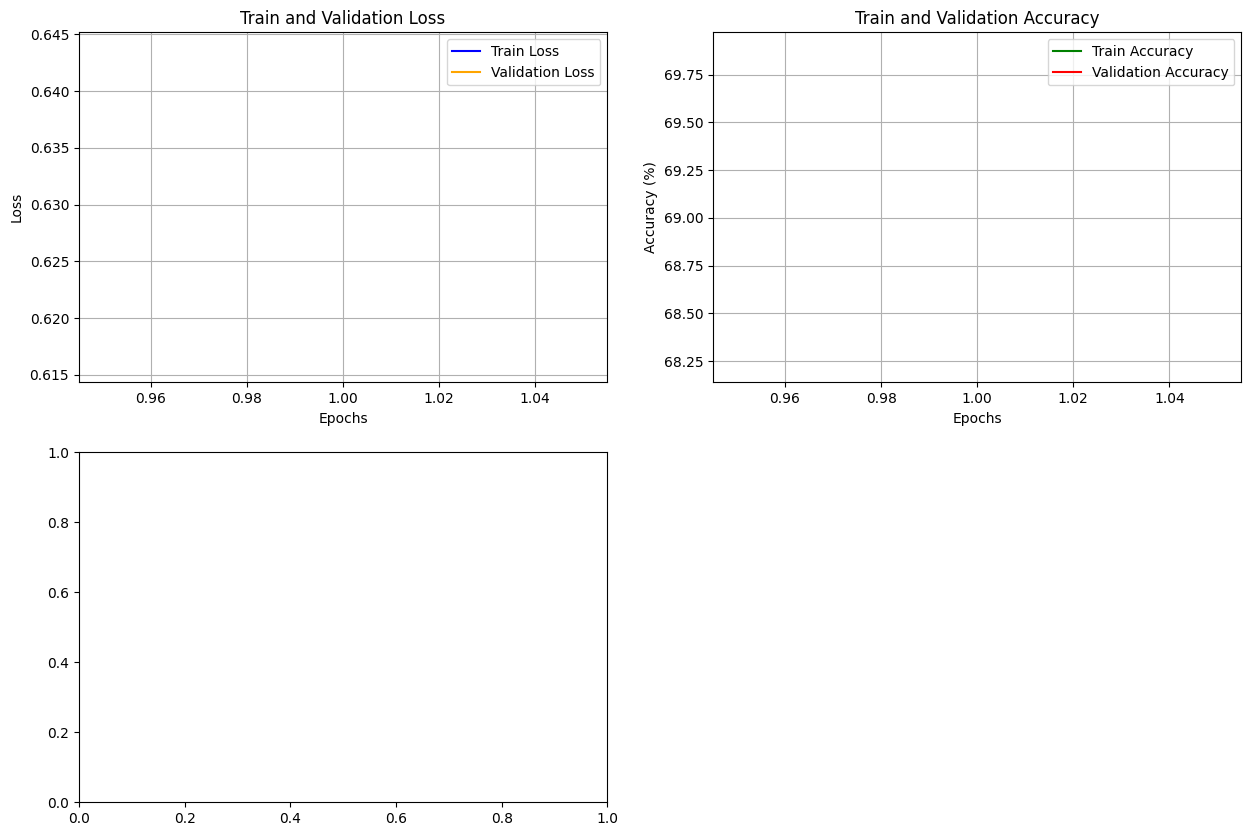

In [110]:
# Построение графиков
plt.figure(figsize=(15, 10))

# График потерь
plt.subplot(2, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='orange')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# График точности
plt.subplot(2, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='green')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='red')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

# График F1 Score
plt.subplot(2, 2, 3)
plt.plot(range(1, num_epochs + 1), train_f1_scores, label='Train F1 Score', color='purple')
plt.plot(range(1, num_epochs + 1), val_f1_scores, label='Validation F1 Score', color='brown')
plt.title('Train and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()

# Отображение графиков
plt.tight_layout()
plt.show()

In [6]:
# Параметры
source_directory = r'D:\data sets\ml-intensive-yandex-academy-autumn-2024\human_poses_data'
csv_train_ans = 'D:\\data sets\\ml-intensive-yandex-academy-autumn-2024\\human_poses_data\\train_answers.csv'
root_dir_train = 'D:\\data sets\\ml-intensive-yandex-academy-autumn-2024\\human_poses_data\\img_train'
root_dir_test = 'D:\\data sets\\ml-intensive-yandex-academy-autumn-2024\\human_poses_data\\img_test'
activity_categories_file = 'activity_categories.csv'

# Преобразования для данных
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=1.5),  # Уменьшение яркости
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Загрузка категорий
activity_categories = pd.read_csv(activity_categories_file)
category_map = dict(zip(activity_categories['id'], activity_categories['category']))

# Класс для пользовательского датасета
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.data_frame.iloc[idx, 0]) + ".jpg")  # ID изображений в первом столбце
        image = Image.open(img_name).convert('RGB')
        label = self.data_frame.iloc[idx, 1]  # Метки во втором столбце

        if self.transform:
            image = self.transform(image)

        return image, label

# Загрузка данных
train_dataset = CustomDataset(csv_file=csv_train_ans, root_dir=root_dir_train, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

# Определение модели (ResNet18)
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

# Инициализация модели
num_classes = len(activity_categories)  # Количество классов в вашем датасете
model = ResNet18(num_classes=num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Для обучения выбран девайс {}".format(device))

model.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 12  # Увеличьте количество эпох по мере необходимости

# Обучение модели
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    correct = 0
    total = 0

    start_time = time.time()  # Запомнить время начала эпохи

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Сохранение меток и предсказаний для F1 Score
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

        # Обновление correct и total
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()  # Запомнить время конца эпохи
    epoch_time = end_time - start_time  # Вычислить время эпохи

    # Вычисление среднего лосса за эпоху
    epoch_loss = running_loss / len(train_loader)

    # Вывод результатов
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {correct / total * 100:.2f}%, Time: {epoch_time:.2f} sec")

print("Обучение завершено!")

# Функция для тестирования модели
class CustomTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data_frame = os.listdir(root_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):

        img_name = os.path.join(self.root_dir, self.data_frame[idx])
        image = Image.open(img_name).convert('RGB')
        label = self.data_frame[idx].replace(".jpg", '')  # Извлечение ID из имени файла

        if self.transform:
            image = self.transform(image)

        return image, int(label)

def get_result(model: torch.nn.Module, transform: transforms.Compose, root_dir_test: str, category_map: dict):
    # Создание тестового датасета и загрузчика
    dataset = CustomTestDataset(root_dir=root_dir_test, transform=transform)
    dl = DataLoader(dataset, batch_size=128)

    model.eval()  # Установка модели в режим оценки
    ans = []

    # Перебор данных в загрузчике
    for img, label in tqdm(dl):
        img = img.to(device)
        label = label.to(device)# Перемещение изображений на устройство
        pred = model(img)  # Предсказания модели
        preds = torch.argmax(pred, dim=1)

        # Конкатенация меток и предсказаний
        res = torch.cat((label.unsqueeze(1), preds.unsqueeze(1)), dim=1)
        ans.extend(res.cpu())
    # Проверка, есть ли данные в ans
    if not ans:
        print("Ошибка: массив ans пуст. Проверьте процесс предсказания.")
        return

    # Преобразование ans в список
    ans = [[element.item() for element in row] for row in ans]

    # Создание списка для сохранения результатов с номерами категорий
    results_with_categories = []
    
    for id, pred in ans:
        results_with_categories.append([id, pred])  # Сохраняем ID и номер предсказанной категории

    # Убедитесь, что файл будет создан в текущей директории
    output_file = 'result.csv'  # Сохраняем в текущей директории

    # Запись результатов в CSV файл
    try:
        with open(output_file, 'w', newline="") as out_file:
            writer = csv.writer(out_file, delimiter=',')
            writer.writerow(['id', 'target_feature'])  # Заголовки
            writer.writerows(results_with_categories)  # Запись данных
        print("Результаты успешно сохранены в", output_file)
    except Exception as e:
        print(f"Ошибка при записи в файл: {e}")

# Вызов функции для получения результатов на тестовых данных
get_result(model, transform, root_dir_test, category_map)

Для обучения выбран девайс cuda:0


Epoch 1/12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [03:13<00:00,  2.00it/s]


Epoch 1/12, Loss: 2.5442, Accuracy: 20.36%, Time: 193.77 sec


Epoch 2/12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [03:13<00:00,  2.00it/s]


Epoch 2/12, Loss: 2.3939, Accuracy: 23.93%, Time: 193.68 sec


Epoch 3/12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [03:13<00:00,  2.00it/s]


Epoch 3/12, Loss: 2.2849, Accuracy: 26.44%, Time: 193.58 sec


Epoch 4/12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [03:13<00:00,  2.00it/s]


Epoch 4/12, Loss: 2.1990, Accuracy: 29.18%, Time: 193.30 sec


Epoch 5/12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [03:12<00:00,  2.01it/s]


Epoch 5/12, Loss: 2.1292, Accuracy: 30.73%, Time: 192.73 sec


Epoch 6/12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [03:14<00:00,  1.99it/s]


Epoch 6/12, Loss: 2.0720, Accuracy: 32.67%, Time: 194.55 sec


Epoch 7/12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [03:13<00:00,  2.00it/s]


Epoch 7/12, Loss: 2.0137, Accuracy: 33.97%, Time: 193.47 sec


Epoch 8/12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [03:15<00:00,  1.98it/s]


Epoch 8/12, Loss: 1.9509, Accuracy: 36.74%, Time: 195.88 sec


Epoch 9/12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [03:16<00:00,  1.97it/s]


Epoch 9/12, Loss: 1.8801, Accuracy: 38.80%, Time: 196.79 sec


Epoch 10/12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [03:13<00:00,  2.00it/s]


Epoch 10/12, Loss: 1.7778, Accuracy: 42.00%, Time: 193.25 sec


Epoch 11/12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [03:12<00:00,  2.01it/s]


Epoch 11/12, Loss: 1.6921, Accuracy: 44.97%, Time: 192.79 sec


Epoch 12/12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [03:14<00:00,  1.99it/s]


Epoch 12/12, Loss: 1.5750, Accuracy: 49.42%, Time: 194.64 sec
Обучение завершено!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [01:42<00:00,  2.45s/it]

Результаты успешно сохранены в result.csv


In [ ]:
# Параметры
source_directory = r'human_poses_data'
csv_train_ans = 'train_answers.csv'
root_dir_train = 'img_train'
root_dir_test = 'img_test'
activity_categories_file = 'activity_categories.csv'

# Преобразования для данных
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=1.5),  # Уменьшение яркости
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Загрузка категорий
activity_categories = pd.read_csv(activity_categories_file)
category_map = dict(zip(activity_categories['id'], activity_categories['category']))

# Класс для пользовательского датасета
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.data_frame.iloc[idx, 0]) + ".jpg")  # ID изображений в первом столбце
        image = Image.open(img_name).convert('RGB')
        label = self.data_frame.iloc[idx, 1]  # Метки во втором столбце

        if self.transform:
            image = self.transform(image)

        return image, label

# Загрузка данных
train_dataset = CustomDataset(csv_file=csv_train_ans, root_dir=root_dir_train, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

# Определение модели (ResNet18)
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

# Инициализация модели
num_classes = len(activity_categories)  # Количество классов в вашем датасете
model = ResNet18(num_classes=num_classes)

device = torch.device("mps")

model.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100  # Увеличьте количество эпох по мере необходимости

# Обучение модели
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    correct = 0
    total = 0

    start_time = time.time()  # Запомнить время начала эпохи

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Сохранение меток и предсказаний для F1 Score
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

        # Обновление correct и total
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()  # Запомнить время конца эпохи
    epoch_time = end_time - start_time  # Вычислить время эпохи

    # Вычисление среднего лосса за эпоху
    epoch_loss = running_loss / len(train_loader)

    # Вывод результатов
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {correct / total * 100:.2f}%, Time: {epoch_time:.2f} sec")

print("Обучение завершено!")

# Функция для тестирования модели
class CustomTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data_frame = os.listdir(root_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):

        img_name = os.path.join(self.root_dir, self.data_frame[idx])
        image = Image.open(img_name).convert('RGB')
        label = self.data_frame[idx].replace(".jpg", '')  # Извлечение ID из имени файла

        if self.transform:
            image = self.transform(image)

        return image, int(label)

def get_result(model: torch.nn.Module, transform: transforms.Compose, root_dir_test: str, category_map: dict):
    # Создание тестового датасета и загрузчика
    dataset = CustomTestDataset(root_dir=root_dir_test, transform=transform)
    dl = DataLoader(dataset, batch_size=128)

    model.eval()  # Установка модели в режим оценки
    ans = []

    # Перебор данных в загрузчике
    for img, label in tqdm(dl):
        img = img.to(device)
        label = label.to(device)# Перемещение изображений на устройство
        pred = model(img)  # Предсказания модели
        preds = torch.argmax(pred, dim=1)

        # Конкатенация меток и предсказаний
        res = torch.cat((label.unsqueeze(1), preds.unsqueeze(1)), dim=1)
        ans.extend(res.cpu())
    # Проверка, есть ли данные в ans
    if not ans:
        print("Ошибка: массив ans пуст. Проверьте процесс предсказания.")
        return

    # Преобразование ans в список
    ans = [[element.item() for element in row] for row in ans]

    # Создание списка для сохранения результатов с номерами категорий
    results_with_categories = []
    
    for id, pred in ans:
        results_with_categories.append([id, pred])  # Сохраняем ID и номер предсказанной категории

    # Убедитесь, что файл будет создан в текущей директории
    output_file = 'result.csv'  # Сохраняем в текущей директории

    # Запись результатов в CSV файл
    try:
        with open(output_file, 'w', newline="") as out_file:
            writer = csv.writer(out_file, delimiter=',')
            writer.writerow(['id', 'target_feature'])  # Заголовки
            writer.writerows(results_with_categories)  # Запись данных
        print("Результаты успешно сохранены в", output_file)
    except Exception as e:
        print(f"Ошибка при записи в файл: {e}")

# Вызов функции для получения результатов на тестовых данных
get_result(model, transform, root_dir_test, category_map)